In [1]:
# Modify the file A00_setup.  Note the working directory is changed
import os
os.chdir(os.getcwd().rsplit(os.path.sep + 'code')[0] + os.path.sep + 'code')
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./A_target_count_encoding/A00_setup.py").load_module()
os.getcwd()

'/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code'

# XGBoost, Target-Thresh/DGI hierarchy: Try Some Alternate Fill Values
Instead of leaving the low volume and unknown NAs, try to fill them with a few things.  This could be relevant for models where NAs are not allowed

*This script takes about 5 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import pickle

In [3]:
from pathlib import Path

In [4]:
import sklearn as sk
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance, partial_dependence
from scikitplot.metrics import plot_lift_curve

In [5]:
from sba_gnn.sba_gnn import sg_plot, sg_target_count_encoder
from sba_gnn.sba_gnn.sg_target_thresh_encoder import TargetThreshEncoder

## Import Processed Datasets

In [6]:
sba_loans = pd.read_parquet(Path(setup.parent_path).joinpath('01_DATA_transformed.parquet')) 

In [7]:
best_params_df = pd.read_csv(Path(setup.parent_path).joinpath('03_REPORT_fit_parameter_selected.csv'))
best_params = best_params_df.to_dict(orient='records')[0]
best_params

{'subsample': 0.8,
 'scale_pos_weight': 1.0,
 'reg_lambda': 0.01,
 'reg_alpha': 0.001,
 'min_child_weight': 50,
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 2}

In [8]:
xgb_params = dict(best_params, 
                   **{'objective':"binary:logistic", 'n_estimators':setup.xgb_n_estimators})

##### Append DGI info

In [9]:
##### DGI info
embed_df = pd.read_parquet(Path(setup.parent_path).joinpath('63_DATA_embeddings_tsne_naics.parquet'))

In [10]:
# Group counts
naics_grp_counts = pd.read_csv(Path(setup.parent_path).joinpath('02_REPORT_naics_grp_stats_all.csv')) \
    [['level_0', 'count_grp']] \
    .drop_duplicates() \
    .set_axis(['naics_type', 'k'], axis=1)

In [11]:
naics_grp_k = naics_grp_counts['k'].drop_duplicates().sort_values().to_list()
naics_grp_k

[20.0, 106.0, 354.0, 834.0]

In [12]:
cluster_cols = sorted([c for c in embed_df if c.startswith('cluster_')],
                      reverse=True)
cluster_cols

['cluster_834',
 'cluster_354',
 'cluster_106',
 'cluster_020',
 'cluster_010',
 'cluster_003']

In [13]:
cluster_cols_sel = sorted([c for c in cluster_cols if int(c.split('_')[1]) in naics_grp_k],
                         reverse=True)
cluster_cols_sel

['cluster_834', 'cluster_354', 'cluster_106', 'cluster_020']

In [14]:
sba_loans = sba_loans.drop(columns = cluster_cols_sel, errors='ignore') \
    .merge(embed_df[['NAICS_orig'] + cluster_cols_sel] \
               .rename(columns={'NAICS_orig':'NAICS'}),
           on='NAICS', how='left')

## Function to get metrics

In [15]:
def get_metrics(data, fill_value = None, enc_features = ['NAICS', 'cluster_020']):
    
    # Alternative encoding
    train_df = data[data['dset'] == 'train']
    enc_dict = {f:TargetThreshEncoder(threshold = setup.selected_lambda_k, fill_value = fill_value) 
                for f in enc_features}
    [enc_dict[f].fit(train_df[f], train_df['target']) for f in enc_features]
    enc_val = pd.concat([enc_dict[f].transform(data[f]) for f in enc_features],
                    axis=1, keys=enc_features)
    enc_val.columns = [c[0] + '_' + c[1] for c in enc_val.columns]
    
    # Append to data
    data = pd.concat([data.drop(columns=enc_val.columns, errors='ignore'), enc_val], 
                      axis=1)
    train_df = data[data['dset'] == 'train']
    test_df = data[data['dset'] == 'test']
    val_df = data[data['dset'] == 'val']
    
    predictor_features = setup.predictor_features + list(enc_val.columns)

    # Model fit
    xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators =  setup.xgb_n_estimators)
    xgb_model = xgb_model.set_params(**xgb_params)
    xgb_model.fit(train_df[predictor_features], train_df['target'],
              eval_set = [(train_df[predictor_features], train_df['target']),
                         (val_df[predictor_features], val_df['target'])])
    
    # Predict
    pred_df = pd.concat([data[['LoanNr_ChkDgt', 'dset', 'target', 'dset_naics_holdout']].reset_index(),
                     pd.DataFrame({'predict_prob':
                                   xgb_model.predict_proba(data[predictor_features])[:,1]})],
                    axis=1) \
    .set_index('index')
    
    # Decision threshold
    pred_train_df = pred_df[pred_df['dset'] == 'train']
    thresh_tune_data = sg_plot.get_f1_frame(pred_train_df['target'], 
                                        pred_train_df['predict_prob'])
    thresh_head = thresh_tune_data.sort_values('f1', ascending=False).head(2)
    best_thresh = thresh_head['thresh'].iloc[0]
    pred_df['predict_bin'] = np.where(pred_df['predict_prob'] >= best_thresh, 1, 0)
    
    # Metrics
    metrics_dset_df = pred_df.groupby('dset') \
        .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()
    metrics_test_df = pred_df[pred_df['dset'] == 'test'] \
        .groupby(['dset', 'dset_naics_holdout']) \
        .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()
    metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
    
    return pred_df, metrics_df

## Loop to get predictions, metrics

In [16]:
# Train mean
target_mean = sba_loans[sba_loans['dset'] == 'train']['target'].mean()
target_mean

0.2046546821975603

In [17]:
count_sets = [None] + sorted([-1, 0, target_mean/2, target_mean, target_mean*1.5, 1])
count_sets

[None, -1, 0, 0.10232734109878015, 0.2046546821975603, 0.30698202329634044, 1]

In [18]:
%%capture
pred_df = pd.DataFrame()
metrics_df = pd.DataFrame()
for c in count_sets:
    this_pred, this_met = get_metrics(sba_loans, c, 
                                     ['NAICS', 'cluster_834', 'cluster_354', 'cluster_106', 'cluster_020'])
    this_pred['c'] = c
    pred_df = pd.concat([pred_df, this_pred])
    this_met['c'] = c
    metrics_df = pd.concat([metrics_df, this_met])

In [19]:
metrics_df[metrics_df['dset_naics_holdout'] == 1]

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout,c
1,test,0.689310,0.415276,0.315556,0.607140,0.349328,0.729352,1.0,None
1,test,0.727726,0.397223,0.332289,0.493698,0.336596,0.725607,1.0,-1
1,test,0.727726,0.397223,0.332289,0.493698,0.336596,0.725607,1.0,0
1,test,0.721192,0.402740,0.329721,0.517300,0.338991,0.724396,1.0,0.102327
1,test,0.681624,0.414232,0.311140,0.619491,0.344683,0.727372,1.0,0.204655
1,test,0.654461,0.424674,0.304452,0.701802,0.349466,0.730626,1.0,0.306982
1,test,0.674768,0.421007,0.311165,0.650706,0.349557,0.730351,1.0,1


In [20]:
metrics_df[metrics_df['dset_naics_holdout'] == 0]

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout,c
0,test,0.659911,0.450985,0.337592,0.679082,0.383476,0.729298,0.0,None
0,test,0.661431,0.450515,0.338139,0.674765,0.385017,0.729671,0.0,-1
0,test,0.661431,0.450515,0.338139,0.674765,0.385017,0.729671,0.0,0
0,test,0.659526,0.450667,0.337261,0.678978,0.384641,0.729073,0.0,0.102327
0,test,0.659194,0.450180,0.336882,0.678302,0.384398,0.729361,0.0,0.204655
0,test,0.658863,0.451302,0.337217,0.682048,0.384905,0.729682,0.0,0.306982
0,test,0.658563,0.451292,0.337067,0.682620,0.383458,0.729448,0.0,1


In [21]:
pred_df.to_parquet(Path(setup.temp_path).joinpath('A19_DATA_combined_predictions.parquet'))
metrics_df.to_csv(Path(setup.temp_path).joinpath('A19_REPORT_metrics.csv'), index=True)

## Quick plot

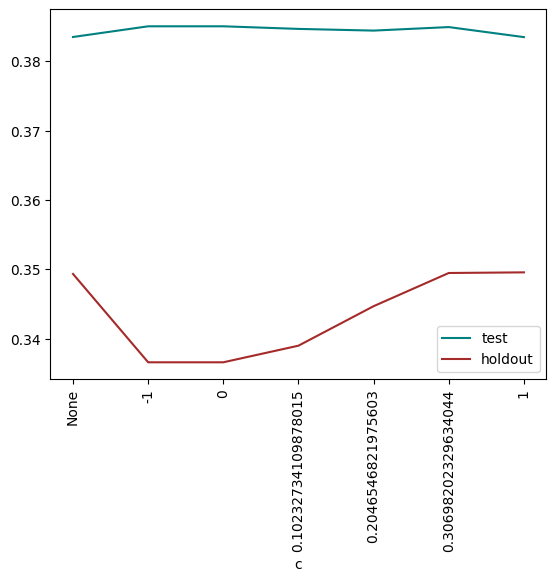

In [22]:
fig, ax = plt.subplots()
metrics_df[metrics_df['dset_naics_holdout'] == 0] \
    .plot(x='c', y='average_precision_score', kind='line', ax=ax, color='teal',
         label='test')
metrics_df[metrics_df['dset_naics_holdout'] == 1] \
    .plot(x='c', y='average_precision_score', kind='line', ax=ax, color='brown',
         label='holdout')
ax.tick_params(axis='x', labelrotation=90)